In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb


In [3]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import wandb

In [80]:
dataset_path = "/content/drive/MyDrive/Akhund-and-Human"


In [81]:
width = height = 299
img_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255 ,
    validation_split=0.1,
)
train_data= img_data_generator.flow_from_directory(
    dataset_path ,
    shuffle=True,
    subset="training",
    target_size=(width,height),
    batch_size=32
)

validation_data = img_data_generator.flow_from_directory(
    dataset_path,
    shuffle=True,
    subset="validation",
    target_size=(width,height),
    batch_size=32
)

Found 421 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


## train_data is an iterator , so :

In [82]:
next(train_data)[0].shape

(32, 299, 299, 3)

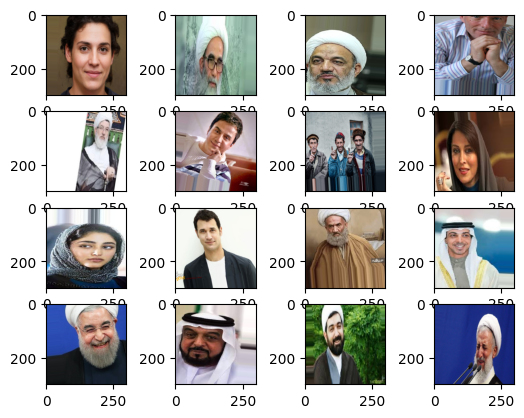

In [83]:
train_images = next(train_data)[0]
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_images[i])

## TransferLearning : weights="imagenet"

In [84]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , input_shape=(width,height,3))
#initial_model.summary()

## include_top = False :

 ## these 2 layers have been deleted :
 ### because of include_top=False
 avg_pool (GlobalAveragePoo(None,1536))                                                           
 predictions (Dense)(None, 1000)

In [85]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , include_top=False , input_shape=(width,height,3))
#initial_model.summary()

## حالا خودمون باید اون دوتا لایه رو بسازیم ::
اما لایه پولینگ رو میتونیم اینجوری بسازیم ::
اینجوری فقط لایه دنس را حذف کردیم

In [86]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                        include_top=False,
                                                        pooling="avg",
                                                        input_shape=(width,height,3))
#initial_model.summary()

# FREEZING SOME LAYERS :

نمیخوایم همه ی لایه ها ترین بشن

## اگر بخوایم چهار لایه آخر شبکه فریز نشوند  :
چهارتای آخر را درنظر نمیگیریم
یعنی میخوایم ۴ لایه آخر شبکه ترین بشوند ولی بقیه نه  

In [87]:
for layer in initial_model.layers[:-4]:
 layer.trainable=False

#initial_model.summary()

In [88]:
model = tf.keras.models.Sequential([
    initial_model,
    tf.keras.layers.Dropout(0.2), # 0.2 is probability that a neuron will be inactive and 80% active
    tf.keras.layers.Dense(2 , activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3074      
                                                                 
Total params: 54339810 (207.29 MB)
Trainable params: 3199490 (12.21 MB)
Non-trainable params: 51140320 (195.08 MB)
_________________________________________________________________


In [89]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001) ,
              loss=tf.keras.losses.categorical_crossentropy ,
              metrics=["accuracy"] )

In [90]:
run = wandb.init(project="Akhund-and-Human")

batch/accuracy,▁▇▇█████████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▇███████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▂▁▂▁▁▁
epoch/val_accuracy,▆▅▆▆▃█▆▅▁▃
epoch/val_loss,▅▄▃▂▆▁▃▂█▄
batch/accuracy,0.99912


In [91]:
from wandb.sdk.wandb_run import wandb_metric
config = wandb.config
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [92]:
history = model.fit(train_data , validation_data=validation_data , epochs=10 , callbacks=wandb_callbacks)


Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.8812

wandb: Adding directory to artifact (./models)... Done. 1.4s


14/14 [==============================] - 206s 14s/step - loss: 0.2745 - accuracy: 0.8812 - val_loss: 0.2515 - val_accuracy: 0.9111
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9572

wandb: Adding directory to artifact (./models)... Done. 2.6s


14/14 [==============================] - 97s 7s/step - loss: 0.0966 - accuracy: 0.9572 - val_loss: 0.3700 - val_accuracy: 0.9333
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9667

wandb: Adding directory to artifact (./models)... Done. 2.3s


14/14 [==============================] - 90s 7s/step - loss: 0.0920 - accuracy: 0.9667 - val_loss: 0.3238 - val_accuracy: 0.9333
Epoch 4/10
14/14 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9762

wandb: Adding directory to artifact (./models)... Done. 1.2s


14/14 [==============================] - 94s 7s/step - loss: 0.0684 - accuracy: 0.9762 - val_loss: 0.2213 - val_accuracy: 0.9333
Epoch 5/10
14/14 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9881

wandb: Adding directory to artifact (./models)... Done. 1.3s


14/14 [==============================] - 92s 7s/step - loss: 0.0399 - accuracy: 0.9881 - val_loss: 0.2008 - val_accuracy: 0.9556
Epoch 6/10
14/14 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9929

wandb: Adding directory to artifact (./models)... Done. 1.2s


14/14 [==============================] - 95s 7s/step - loss: 0.0262 - accuracy: 0.9929 - val_loss: 0.3356 - val_accuracy: 0.9333
Epoch 7/10
14/14 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9952

wandb: Adding directory to artifact (./models)... Done. 1.2s


14/14 [==============================] - 91s 7s/step - loss: 0.0310 - accuracy: 0.9952 - val_loss: 0.3560 - val_accuracy: 0.9333
Epoch 8/10
14/14 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9881

wandb: Adding directory to artifact (./models)... Done. 2.3s


14/14 [==============================] - 94s 7s/step - loss: 0.0311 - accuracy: 0.9881 - val_loss: 0.1885 - val_accuracy: 0.9556
Epoch 9/10
14/14 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9905

wandb: Adding directory to artifact (./models)... Done. 1.3s


14/14 [==============================] - 89s 7s/step - loss: 0.0271 - accuracy: 0.9905 - val_loss: 0.1843 - val_accuracy: 0.9333
Epoch 10/10
14/14 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9881

wandb: Adding directory to artifact (./models)... Done. 1.3s


14/14 [==============================] - 96s 7s/step - loss: 0.0334 - accuracy: 0.9881 - val_loss: 0.2387 - val_accuracy: 0.9333


| Layers Freezed|without Dropout| with Droput = 0.2 |with Droput = 0.5 |
| ------------- | :-------------: | :-------------: |:-------------: |
| validation Accuracy  | --  | 0.9333  | --  |

---




In [118]:
model.save("/content/drive/MyDrive/Human_Akhund_weights.keras")

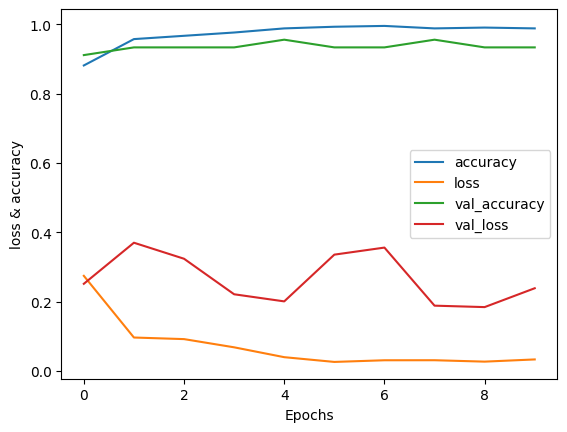

In [94]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.plot(history.history["val_loss"])
plt.legend(["accuracy","loss" , "val_accuracy" , "val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.show()

In [95]:
#y_pred = model.predict(validation_data)
#y_predlist = np.array(list(y_pred))
#print(y_predlist[5])
#print(np.argmax(y_predlist[5]))
#ypred_list = []
#for i in range(len(y_predlist)):
#  ypred_list.append(np.argmax(y_predlist[i]))

#print(ypred_list)

In [ ]:
images,labels = validation_data[1]
ypred_list = []
for image in images:
    image = np.expand_dims(image, axis=0)
    ypred=model.predict(image)
    ypred_list.append(np.argmax(ypred))
ytrue_list = []
for label in labels:
    ytrue_list.append(np.argmax(label))

In [97]:
np.array(ytrue_list)

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [98]:
np.array(ypred_list)

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

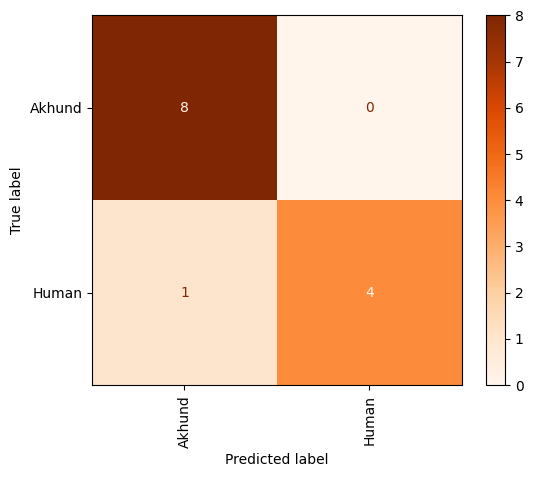

In [99]:
confm = metrics.confusion_matrix(y_true= ytrue_list , y_pred= ypred_list  )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confm , display_labels=['Akhund','Human'])
cm_display.plot(cmap=plt.cm.Oranges , xticks_rotation="vertical")
plt.show()

# Inference

In [100]:
#model= tf.keras.models.load_model("/content/drive/MyDrive/5animals_weights.keras")

شبکه همیشه تصاویر را به صورت بچ میخواد از ما . یعنی ورودی شبکه همیشه ۴ بعدی است .
یکی از این ۴ تا بعد بچ سایز است
اما حالا که فقط میخوایم یک تصویر بدیم بازم باید تصویر رو ۴ بعدی بکنیم


1/1 [==============================] - 0s 67ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund


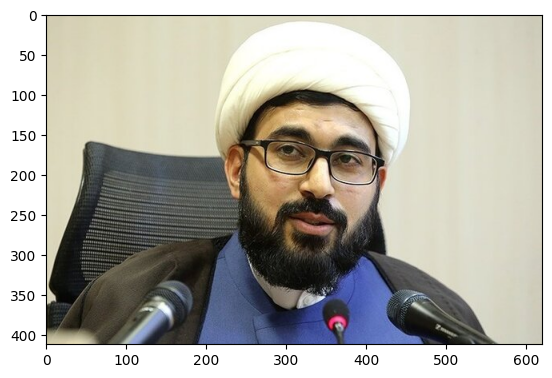

In [101]:
import cv2

new_image = cv2.imread("/content/a1.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 74ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund


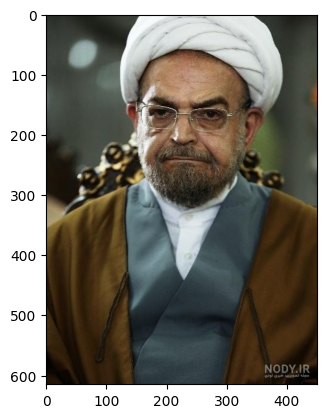

In [102]:
new_image = cv2.imread("/content/a2.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 59ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human


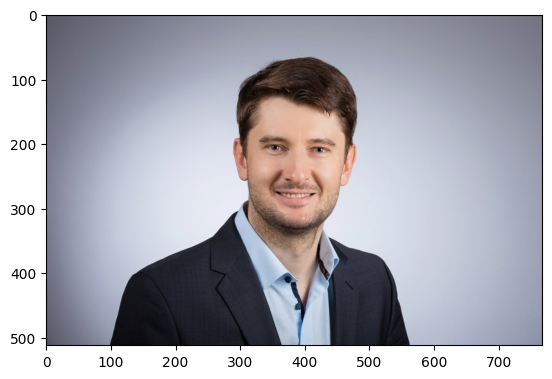

In [103]:
new_image = cv2.imread("/content/hu2.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 48ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human


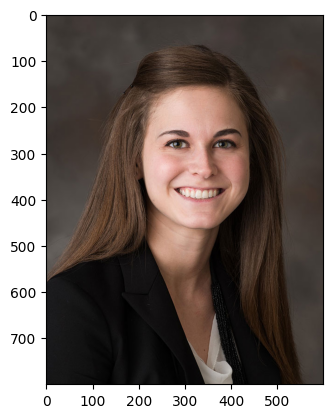

In [104]:
new_image = cv2.imread("/content/hu1.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 95ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund


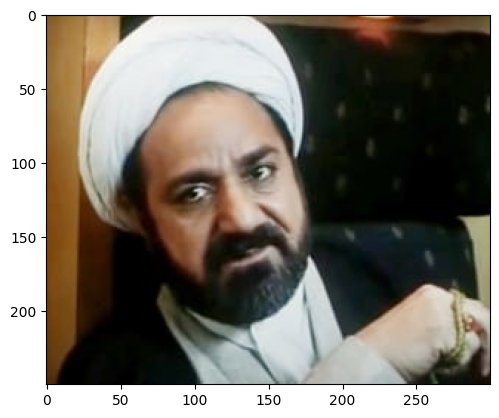

In [105]:
new_image = cv2.imread("/content/a3.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 70ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund


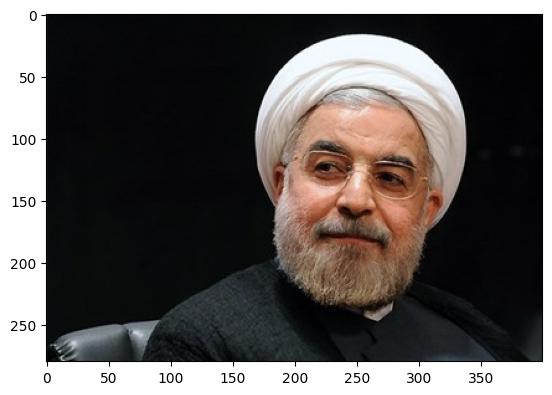

In [106]:
new_image = cv2.imread("/content/a5.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 52ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human


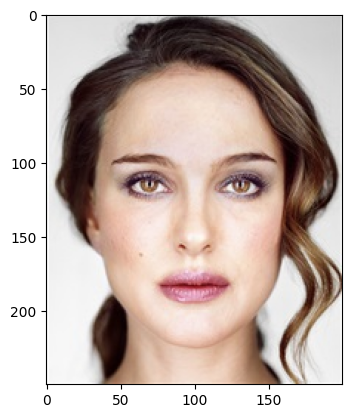

In [107]:
new_image = cv2.imread("/content/hu5.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 44ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human


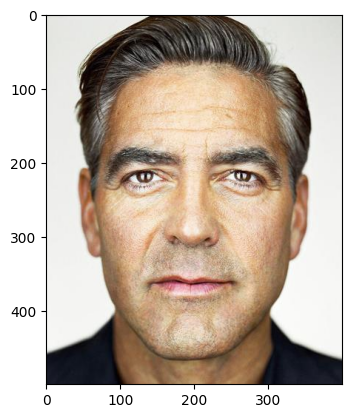

In [108]:
new_image = cv2.imread("/content/h6.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

# telegram bot :


In [2]:
!pip install TeleBot
!pip install pyTelegramBotAPI
!pip install pytesseract
!pip install telegram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.14.0-py3-none-any.whl size=215251 sha256=3a00d6dc2c790f633dd93b5423c87799d587c03d2c0301ec6e79894399c85f1a
  Stored in directory: /root/.cache/pip/wheels/25/51/2d/24b40a366c85c37928d5aa36ddf257e5a79fad25e1ecd11b2c
Successfully built pyTelegramBotAPI
  Preparing metadata (setup.py) ... done
  Created wheel for telegram: filename=telegram-0.0.1-py3-none-any.whl size=1293 sha256=403e4ca60470cf126308d4dec071b7597e6780e745a36fc2a1c05f7bb045c3e4
  Stored in directory: /root/.cache/pip/wheels/f3/f2/16/dc6d6c6c7e0422206fec62833039a2b4082de3b85e55d32b52
Successfully built telegram


In [12]:
import cv2
import numpy as np
import telebot
from telebot import types
from telegram import *
import telebot
import pytesseract
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from dotenv import load_dotenv
# from os import environ as env


dataset_path = "/content/drive/MyDrive/Akhund-and-Human"
width = height = 299
img_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255 ,
    validation_split=0.1,
)
train_data= img_data_generator.flow_from_directory(
    dataset_path ,
    shuffle=True,
    subset="training",
    target_size=(width,height),
    batch_size=32
)

validation_data = img_data_generator.flow_from_directory(
    dataset_path,
    shuffle=True,
    subset="validation",
    target_size=(width,height),
    batch_size=32
)
#load_dotenv()
#token = os.getenv('TOKEN')
bot = telebot.TeleBot("6553415592:AAHWgAXRq9a2a6jX2_2jaMHbUyseT7onjos")
model = load_model("/content/drive/MyDrive/Human_Akhund_weights.keras")



@bot.message_handler(commands=['start']) #decorator
def send_welcome(message):

  bot.send_message(message.chat.id , " Hi " + message.from_user.first_name + "\nWelcome to Human VS Akhund Recognition bot ")
  HA_recognizer(message)


counter = 0
@bot.message_handler()
def HA_recognizer(message):
    global counter
    if counter == 0 :
      initial_message = bot.send_message(message.chat.id, "Upload a HUMAN👩🏻 OR Akhund💩👳🏻‍♂️ image 🔄 ... " + "\nAnd wait for the result ...  " )
      bot.register_next_step_handler(initial_message , human_recognizer)
      counter += 1
    elif counter != 0 :
      initial_message = bot.send_message(message.chat.id, "Did you like it 😏? \nSo Upload another image 🔄 :  " )
      bot.register_next_step_handler(initial_message , human_recognizer)
def human_recognizer(message):
    file_id = message.photo[-1].file_id
    file_path = bot.get_file(file_id).file_path
    downloaded_file = bot.download_file(file_path)
    try:
        with open("image.jpg", 'wb') as new_file:
            new_file.write(downloaded_file)
    except Exception as e:
        bot.reply_to(message, "Error saving file.")
        return

    # Open image
    try:
        image = Image.open("image.jpg")
    except Exception as e:
        bot.reply_to(message, "Error opening file.")
        return

    # Get text from image
    #bot.send_photo(chat_id=message.chat.id, photo=image)
    # file = context.bot.get_file(update.message.document.file_id)


    new_image = cv2.imread("image.jpg")
    new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(new_image , (299,299))
    new_image = new_image / 255.0
    new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

    output = model.predict(new_image)

    predicted_class = np.argmax(output)
    print(predicted_class)
    print(train_data.class_indices)
    mylist = list(train_data.class_indices)
    print("predicted label : " , mylist[np.argmax(output)])
    if mylist[np.argmax(output)] == "Akhund" :
        bot.send_message(message.chat.id,  "از ما نیست 👳🏻‍♂️❌")
    elif mylist[np.argmax(output)] == "Human" :
        bot.send_message(message.chat.id,  "از ماست ✅")
    HA_recognizer(message)


bot.infinity_polling()

Found 421 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human
1/1 [==============================] - 0s 343ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human
1/1 [==============================] - 0s 360ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human
1/1 [==============================] - 0s 341ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human
1/1 [==============================] - 0s 352ms/step
1
{'Akhund': 0, 'Human': 1}
predicted label :  Human
1/1 [==============================] - 0s 340ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund
1/1 [==============================] - 0s 344ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund
1/1 [==============================] - 0s 341ms/step
0
{'Akhund': 0, 'Human': 1}
predicted label :  Akhund
1/1 [==============================] - 0s 341ms/step
1
{'Akhund': 0, 'H

2023-10-28 10:49:20,538 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2023-10-28 10:49:20,541 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling
